# Business Problem
* Date: The date.
* Open: The opening price of the stock.
* High: The high price of that day.
* Low: The low price of that day.
* Close: The closed price of that day.
* Adj Close: The stock's closing price that has been amended to include any distributions/corporate actions that occurs before next days open.
* Volume: The amount of stocks traded during that day

In [340]:
#Libraries to be used in the step of reading and processing the data

import numpy as np
import pandas as pd
#pip install tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt

#Libraries to be used for Model Evaluation and scaling of data

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_squared_error

#Libraries to be used for the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Used to turn off warnings

import warnings
warnings.filterwarnings('ignore')

#Tensorflow Warning Suppression
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [341]:
df = pd.read_csv("C:/Projects/Huge Stock Market Dataset/Stocks/tsla.us.txt")

In [342]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0


In [343]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
1853,2017-11-06,307.00,307.50,299.01,302.78,6482486,0
1854,2017-11-07,301.02,306.50,300.03,306.05,5286320,0
1855,2017-11-08,305.50,306.89,301.30,304.31,4725510,0
1856,2017-11-09,302.50,304.46,296.30,302.99,5440335,0
1857,2017-11-10,302.50,308.36,301.85,302.99,4621912,0


In [344]:
def check_df(dataframe, head=5):
    print("---------------- Shape ----------------")
    print(dataframe.shape)

    print("---------------- Types ----------------")
    print(dataframe.dtypes)

    print("---------------- Head ----------------")
    print(dataframe.head(head))

    print("---------------- Tail ----------------")
    print(dataframe.tail(head))

    print("---------------- NA ----------------")
    print(dataframe.isnull().sum())

    print("---------------- Quantiles ----------------")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

---------------- Shape ----------------
(1858, 7)
---------------- Types ----------------
Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
---------------- Head ----------------
         Date   Open   High    Low  Close    Volume  OpenInt
0  2010-06-28  17.00  17.00  17.00  17.00         0        0
1  2010-06-29  19.00  25.00  17.54  23.89  18783276        0
2  2010-06-30  25.79  30.42  23.30  23.83  17194394        0
3  2010-07-01  25.00  25.92  20.27  21.96   8229863        0
4  2010-07-02  23.00  23.10  18.71  19.20   5141807        0
---------------- Tail ----------------
            Date    Open    High     Low   Close   Volume  OpenInt
1853  2017-11-06  307.00  307.50  299.01  302.78  6482486        0
1854  2017-11-07  301.02  306.50  300.03  306.05  5286320        0
1855  2017-11-08  305.50  306.89  301.30  304.31  4725510        0
1856  2017-11-09  302.50  304.46  296.30  302.99  5

In [345]:
df["Date"]=pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0


# Preparing the Data

In [346]:
stock_df=df[["Date","Close"]]
stock_df.head()

,Date,Close
0,2010-06-28,17.00
1,2010-06-29,23.89
2,2010-06-30,23.83
3,2010-07-01,21.96
4,2010-07-02,19.20


In [347]:
print("Min. Date - ", stock_df["Date"].min())
print("Max. Date - ", stock_df["Date"].max())

Min. Date -  2010-06-28 00:00:00
Max. Date -  2017-11-10 00:00:00


In [348]:
stock_df.index=stock_df["Date"]
stock_df

,Date,Close
Date,,
2010-06-28,2010-06-28,17.00
2010-06-29,2010-06-29,23.89
2010-06-30,2010-06-30,23.83
2010-07-01,2010-07-01,21.96
2010-07-02,2010-07-02,19.20
...,...,...
2017-11-06,2017-11-06,302.78
2017-11-07,2017-11-07,306.05
2017-11-08,2017-11-08,304.31


In [349]:
stock_df.drop("Date",axis=1,inplace=True)
stock_df

,Close
Date,
2010-06-28,17.00
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.20
...,...
2017-11-06,302.78
2017-11-07,306.05
2017-11-08,304.31


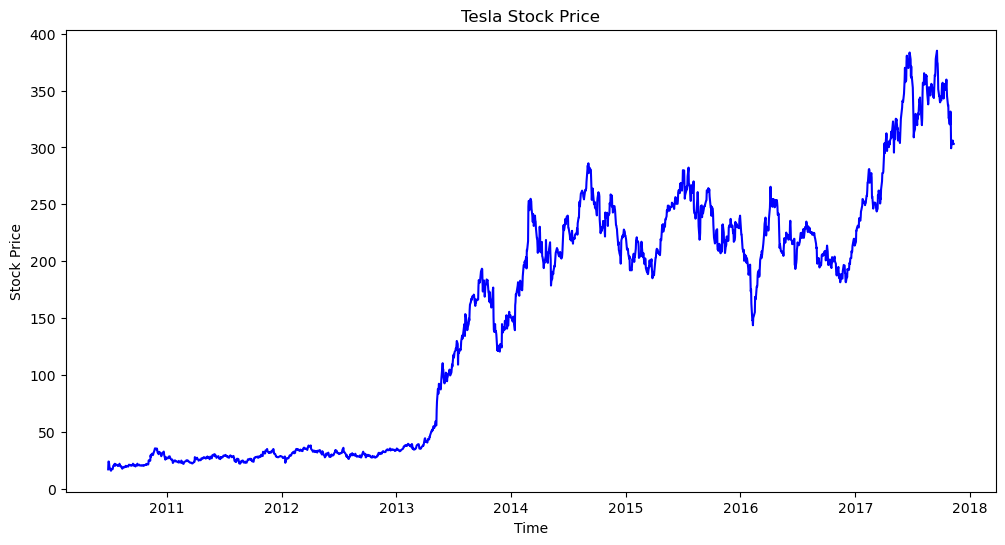

In [350]:
result_df=stock_df.copy()

plt.figure(figsize=(12,6))
plt.plot(stock_df["Close"],color="blue")
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("Tesla Stock Price")
plt.show()

**Converting to Numpy Array**

In [351]:
stock_df=stock_df.values
stock_df[0:5]

array([[17.  ],
       [23.89],
       [23.83],
       [21.96],
       [19.2 ]])

**Defining float 32 for Neural Network**

In [352]:
stock_df=stock_df.astype("float32")

**Let's make Train-Test distinction as a function**

In [353]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos

train,test,pos=split_data(stock_df,0.20)
print(train.shape,test.shape)

(1486, 1) (372, 1)


In [354]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
train[0:5]

array([[0.00444049],
       [0.02993634],
       [0.02971432],
       [0.02279454],
       [0.01258141]], dtype=float32)

In [355]:
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)
test[0:5]

array([[0.17912066],
       [0.187325  ],
       [0.21454191],
       [0.20432329],
       [0.2052567 ]], dtype=float32)

In [356]:
def create_features(data,lookback):
    x,y=[],[]
    for i in range(lookback,len(data)):
        x.append(data[i-lookback:i,0])
        y.append(data[i,0])
    return np.array(x),np.array(y)

lookback=30

**Train & Test Data Set**

In [357]:
x_train,y_train=create_features(train,lookback)
x_test,y_test=create_features(test,lookback)

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1456, 30) (1456,) (342, 30) (342,)


**There are 30 features in total here, so we added the day 30 days before the relevant date to the data set**

In [358]:
x_train[0:5]

array([[0.00444049, 0.02993634, 0.02971432, 0.02279454, 0.01258141,
        0.00114713, 0.        , 0.00614268, 0.00592066, 0.00462551,
        0.00865897, 0.01494967, 0.01513469, 0.01791   , 0.02260953,
        0.01665186, 0.01635583, 0.01924215, 0.02031527, 0.01905713,
        0.01757696, 0.01820603, 0.01683688, 0.01531971, 0.01894612,
        0.02275755, 0.02020426, 0.01720693, 0.01402457, 0.01406157],
       [0.02993634, 0.02971432, 0.02279454, 0.01258141, 0.00114713,
        0.        , 0.00614268, 0.00592066, 0.00462551, 0.00865897,
        0.01494967, 0.01513469, 0.01791   , 0.02260953, 0.01665186,
        0.01635583, 0.01924215, 0.02031527, 0.01905713, 0.01757696,
        0.01820603, 0.01683688, 0.01531971, 0.01894612, 0.02275755,
        0.02020426, 0.01720693, 0.01402457, 0.01406157, 0.01195234],
       [0.02971432, 0.02279454, 0.01258141, 0.00114713, 0.        ,
        0.00614268, 0.00592066, 0.00462551, 0.00865897, 0.01494967,
        0.01513469, 0.01791   , 0.02260953, 0.

In [359]:
y_train[0:5]

array([0.01195234, 0.00777087, 0.00666074, 0.00932504, 0.01102723],
      dtype=float32)

**Stock Closing Prices**

In [360]:
x_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
x_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1456, 1, 30) (1456, 1) (342, 1, 30) (342, 1)


# Modeling

In [361]:
model=Sequential()
model.add(LSTM(units=100,
               activation="relu",
               input_shape=(x_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               52400     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


In [362]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [363]:
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",save_best_only=True,save_weights_only=False,verbose=1)]

In [364]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=200,
                    batch_size=30,
                    validation_data=(x_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/200
35/49 [====================>.........] - ETA: 0s - loss: 0.0057    
Epoch 1: val_loss improved from inf to 0.00898, saving model to mymodel.h5
49/49 [==============================] - 2s 9ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 2/200
35/49 [====================>.........] - ETA: 0s - loss: 0.0044
Epoch 2: val_loss improved from 0.00898 to 0.00815, saving model to mymodel.h5
49/49 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0082
Epoch 3/200
36/49 [=====================>........] - ETA: 0s - loss: 0.0034    
Epoch 3: val_loss improved from 0.00815 to 0.00747, saving model to mymodel.h5
49/49 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 4/200
47/49 [===========================>..] - ETA: 0s - loss: 0.0053
Epoch 4: val_loss improved from 0.00747 to 0.00692, saving model to mymodel.h5
49/49 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0069
Epoch 5/200
46/49 [=========

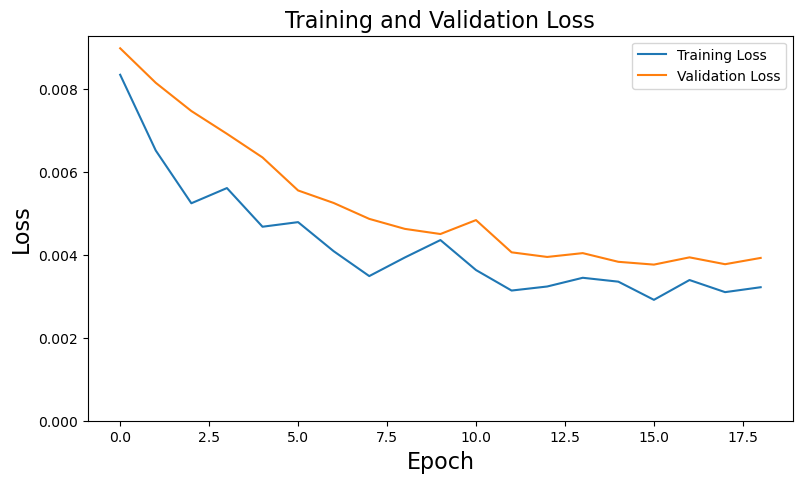

In [365]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

**The expression loss is the mean squared error value, that is, the mean squared expression of the actual values and the estimated values**

# Evaluation

In [366]:
loss=model.evaluate(x_test,y_test,batch_size=30)
print("\nTest loss:%.1f%%"%(100.0*loss))

12/12 [==============================] - 0s 1ms/step - loss: 0.0039

Test loss:0.4%


In [367]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

11/11 [==============================] - 0s 0s/step


In [368]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [369]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

**RMSE value to train dataset**

In [370]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))

In [371]:
print(f"Train RMSE - {train_rmse}")
print(f"Test RMSE - {test_rmse}")

Train RMSE - 9.909297943115234
Test RMSE - 12.756081581115723


**The mistake Tesla Stock Market will be made in the next period is 13 dollars**

In [372]:
train_prediction_data=result_df[lookback:pos]
train_prediction_data["Predicted"]=train_predict
train_prediction_data.head()

,Close,Predicted
Date,,
2010-08-10,19.03,22.340857
2010-08-11,17.90,22.261044
2010-08-12,17.60,22.241150
2010-08-13,18.32,22.225958
2010-08-16,18.78,22.224825


In [373]:
test_prediction_data=result_df[pos+lookback:]
test_prediction_data["Predicted"]=test_predict
test_prediction_data.head()

,Close,Predicted
Date,,
2016-07-07,215.94,212.811951
2016-07-08,216.78,213.702942
2016-07-11,224.78,213.510590
2016-07-12,224.65,215.208267
2016-07-13,222.53,217.051941


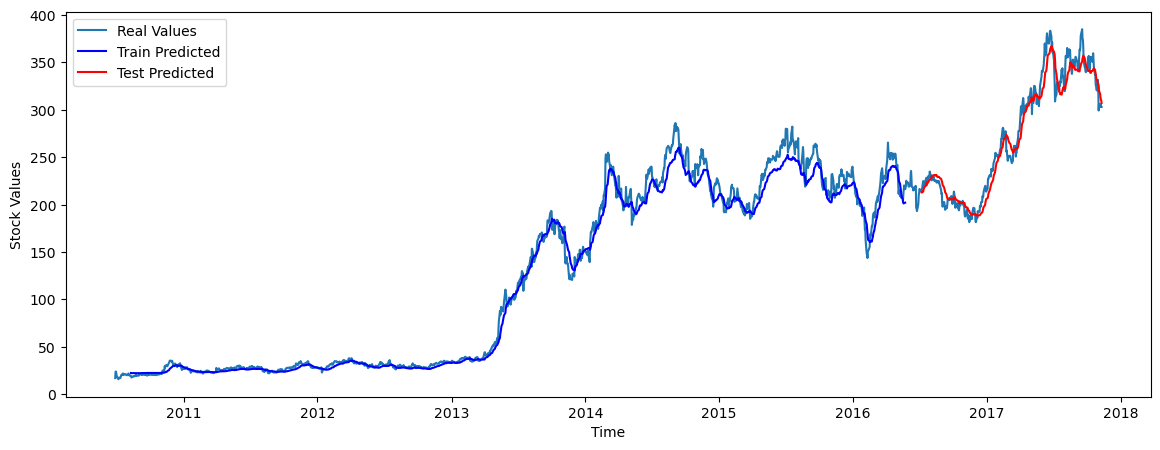

In [374]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()